# **Preprocessing_NER**

## **Author:** Gema De Vargas Romero

## **Master Thesis:** "Development of a Named Entity Recognition System to automatically assign tumor morphology entity mentions to health-related documents in Spanish." 


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

path='drive/My Drive/Ejemplos NER - TFM/'
!ls 'drive/My Drive/Ejemplos NER - TFM/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
 bert
 check_results2.ipynb
 check_results.ipynb
 data
 dev_set
 dev_set2
'Dictionary based NER (spacy).ipynb'
'Ehealth_Dictionary based NER (spacy).ipynb'
 last_step_cantemist.ipynb
 last_step_cantemist_TEST.ipynb
 NER_by_BERT_Cantemist_BIOESV.ipynb
 NER_by_BERT_Cantemist_Competicion.ipynb
 NER_by_BERT_Cantemist.ipynb
 NER_by_BI_LSTM_CRF_Cantemist_BIOESV_2.ipynb
 NER_by_BI_LSTM_CRF_Cantemist_BIOESV.ipynb
 NER_by_BI_LSTM_CRF_Cantemist_Competicion.ipynb
 NER_b

## **Loading libraries**

In [ ]:
!pip install sklearn-crfsuite
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_precision_score
from sklearn_crfsuite.metrics import flat_recall_score
from sklearn_crfsuite.metrics import flat_classification_report
import numpy as np
import pandas as pd
import time
import random
#import nltk
import matplotlib.pyplot as plt

     |████████████████████████████████| 747kB 2.0MB/s 


In [ ]:
# Library spacy
!pip install -U spacy 
#!python -m spacy validate
!python -m spacy download es_core_news_lg
import spacy

# nlp = spacy.load("es") # no longer works with updated version of spacy 2.3.1
import es_core_news_lg
nlp = es_core_news_lg.load()

     |████████████████████████████████| 10.0MB 1.8MB/s 
     |████████████████████████████████| 2.1MB 36.1MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 573.1MB 1.2MB/s 
  Created wheel for es-core-news-lg: filename=es_core_news_lg-2.3.1-cp36-none-any.whl size=573139081 sha256=6f52d840e1567471adab587c36f274eb06ae5cb2855971c493b55740f4ab2da2
  Stored in directory: /tmp/pip-ephem-wheel-cache-2fnfqehp/wheels/48/59/33/558e7f48e924c6cac0cbd3679ee7c84f5ae02964c335232e5a
Successfully built es-core-news-lg
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_lg')


## **Cantemist dataset:**

Training foulder:

The annotated files can have Entities and Relations.

The entity can be formed by more than one word. The position of each word is separated by ';'


The start-offset is the index of the first character of the annotated span in the text 

The end-offset is the index of the first character after the annotated span. Thus, the character in the end-offset position is not included in the annotated span


### **Loading the files**

In [ ]:
def read_data_ann(files_txt, files_ann):
  data_txt = []
  ann = []

  # Reading .txt files
  for file in files_txt:     
    f=open(file, mode = 'r')  
    data_txt.append(f.read())
    f.close()

  # Reading .ann files
  for file in files_ann:     
    f=open(file, mode = 'r')
    lines = f.readlines()
    ann_aux = []

    for line in lines:
      # We are only interested in keeping the entities: ID starts by T.
      # Remove relations: starting by R     
      if str(line[0])== 'T':
        data_ann = line.split("\t")
        ann_aux.append(data_ann)  

    ann.append(ann_aux)   
    f.close()

  return data_txt, ann

#### **Reading the train files**

In [ ]:
# READING THE .txt AND .ann FILES

path_Cantemist_train = path+"train_set/cantemist-ner/"

# code to read all the files in this folder
# There are 501 annotated files (.ann) and 501 txt file
# The txt and ann files share the same name.  Ex. cc_onco85.ann and cc_onco85.txt

import glob   

path_txt_train = path_Cantemist_train +'*.txt'   
path_ann_train = path_Cantemist_train +'*.ann'  

files_txt_train = glob.glob(path_txt_train)   
files_ann_train = glob.glob(path_ann_train)   

# Sort the files to read the .txt and .ann files in the same order
files_txt_train = sorted(files_txt_train)
files_ann_train = sorted(files_ann_train)

data_txt_train, ann_train = read_data_ann(files_txt_train, files_ann_train)

In [ ]:
# Storing the names of the txt files into a list: names_txt
len_path = len(path_Cantemist_train)
names_txt_train = [files_txt_train[i][len_path:] for i in range(len(files_txt_train))]
print(names_txt_train[:3]) # the names of the files with the sentences

# Storing the names of the ann files into a list: names_txt
names_ann_train = [files_ann_train[i][len_path:] for i in range(len(files_ann_train))]
print(names_ann_train[:3]) # the names of the files with the sentences

# As it can be observed there are pairs of .txt and .ann files stored with the same name 
# Before reading them, they were sorted so they were read in the same order

print("\nNumber of .txt files read: %d" %len(files_txt_train))
print("\nNumber of .ann files read: %d" %len(files_ann_train))

['cc_onco1.txt', 'cc_onco10.txt', 'cc_onco1000.txt']
['cc_onco1.ann', 'cc_onco10.ann', 'cc_onco1000.ann']

Number of .txt files read: 501

Number of .ann files read: 501


**Example file 60:**

**1. txt file: data_txt[59]**

Anamnesis
Varón de 57 años, residente en núcleo rural y agricultor de profesión, refería contacto habitual con fertilizantes. No tenía alergias medicamentosas conocidas ni antecedentes personales de interés, salvo la extirpación de un carcinoma basocelular de la mejilla derecha en 2013.
No tomaba tratamiento médico habitual.
Consultó en su médico de atención primaria por disfagia mixta progresiva de 12 meses de evolución sin otra clínica acompañante. Había perdido 14 kg en los últimos 8 meses de manera voluntaria.
El resto de la anamnesis por aparatos no reflejaba datos relevantes.

Exploración física
El paciente presentaba buen estado general, ECOG1, y la exploración física rsultaba anodina. El abdomen era blando y depresible, no doloroso y no se palpaban masas ni megalias.

Pruebas complementarias
» La primera prueba complementaria realizada fue una gastroscopia que demostraba la presencia de una lesión exofítica irregular, dura y friable a 35 cm de la arcada dental, en la unión esofagogástrica (UGE), que impedía el paso del endoscopio. Las biopsias tomadas de la lesión fueron compatibles con adenocarcinoma indiferenciado.
» El estudio se completó con una TC toracoabdominal que confirmaba la presencia de un tumor en la unión esofagogástrica y de adenopatías yuxtaesofágicas y en ligamento gastrohepático. No se identificaban metástasis a distancia.
» Los marcadores tumorales (CEA y Ca 19,9) se encontraban dentro de los límites de la normalidad.

Diagnóstico
Con el diagnóstico de adecarcinoma indiferenciado de UGE localmente avanzado (cT3N+) se presentó en el Comité Multidisciplinar de Tumores esofagogástricos y se optó por la intervención quirúrgica.

Tratamiento
Se realizó una esofaguectomía total y gastrectomía de tercio superior tipo Ivor-Lewis.

El estudio anatomopatológico de la pieza quirúrgica mostraba un patrón glandular compatible con adenocarcinoma pobremente diferenciado grado 3 difuso con células en anillo de sello de la UGE que infiltraba todas las capas de la mucosa gástrica. Presentaba extensa linfangitis carcinomatosa extramural, infiltración de linfáticos perineurales e infiltración metastásica en 15 de los 23 ganglios extirpados por células de adenocarcinoma. Por la clasificación TNM se trataba de un pT3N3, estadio IIIC.

El análisis inmunohistoquímico, sin embargo, revelaba positividad par citoqueratina 7 y de forma extensa y difusa positividad para sinaptofisina, cromogranina y E-cadherina en las membranas celulares; el Ki-67% era superior al 60% en más del 30% de las células. HER-2 no estaba amplificado.
Todo ello confería al tumor una diferenciación neuroendocrina.
Teniendo en cuenta el resultado IHQ y el patrón aquitectural de la muestra, el diagnóstico final fue de tumor mixto: adenocarcinoma pobremente diferenciado con células en anillo de sello y carcinoma neuroendocrino con Ki-67 del 60% de la UGE (MANEC). pT3N3. Estadio IIIC.

Evolución
Ante el diagnóstico definitivo y atendiendo a la agresividad de ambos componentes histológicos, optamos por un esquema de quimioterapia activo frente a ambos componentes basado en cisplatino y capecitabina adyuvantes; tratamiento que continua recibiendo actualmente con buena tolerancia.

**2. annotation file: ann[59]**

In [ ]:
ann_train[59]

[['T1', 'MORFOLOGIA_NEOPLASIA 2200 2214', 'adenocarcinoma\n'],
 ['T2', 'MORFOLOGIA_NEOPLASIA 235 256', 'carcinoma basocelular\n'],
 ['T3', 'MORFOLOGIA_NEOPLASIA 2823 2847', 'carcinoma neuroendocrino\n'],
 ['T4', 'MORFOLOGIA_NEOPLASIA 2044 2069', 'linfangitis carcinomatosa\n'],
 ['T5', 'MORFOLOGIA_NEOPLASIA 2137 2148', 'metastásica\n'],
 ['T6', 'MORFOLOGIA_NEOPLASIA 1347 1357', 'metástasis\n'],
 ['T7', 'MORFOLOGIA_NEOPLASIA 1229 1234', 'tumor\n'],
 ['T8', 'MORFOLOGIA_NEOPLASIA 2738 2749', 'tumor mixto\n'],
 ['T9', 'MORFOLOGIA_NEOPLASIA 1112 1141', 'adenocarcinoma indiferenciado\n'],
 ['T10', 'MORFOLOGIA_NEOPLASIA 1504 1531', 'adecarcinoma indiferenciado\n'],
 ['T11',
  'MORFOLOGIA_NEOPLASIA 1876 1960',
  'adenocarcinoma pobremente diferenciado grado 3 difuso con células en anillo de sello\n'],
 ['T12',
  'MORFOLOGIA_NEOPLASIA 2593 2632',
  'tumor una diferenciación neuroendocrina\n'],
 ['T13',
  'MORFOLOGIA_NEOPLASIA 2751 2820',
  'adenocarcinoma pobremente diferenciado con células en a

In [ ]:
# Example employing the first file: 
print("Name of the first file is: %s" %names_txt_train[0])

print("\nIts corresponding annotated file is:\n")
print(ann_train[0])

# This annotated file states that there are 12 entities in the first file (BRAT format)
# first column: Entity ID
# second column: Entity Type
# Third column: Start_End_offset
# fourth column: Entity (formed by one or various words)

# The first line indicates that there is an entity "carcinoma renal de células claras" in the txt
# file, that starts at character 4603 and ends at character 4636 and is formed by 5 words
print("\nThe characters in the position defined by the first entity are: %s" %(data_txt_train[0][4603:4636]))

# Indeed, they are the same

Name of the first file is: cc_onco1.txt

Its corresponding annotated file is:

[['T1', 'MORFOLOGIA_NEOPLASIA 2719 2740', 'Carcinoma microcítico\n'], ['T2', 'MORFOLOGIA_NEOPLASIA 2950 2971', 'carcinoma microcítico\n'], ['T3', 'MORFOLOGIA_NEOPLASIA 2988 2990', 'M0\n']]

The characters in the position defined by the first entity are: echo y un nódulo de 7 mm en lóbul


#### **Reading the development files**

In [ ]:
# READING THE .txt AND .ann FILES

path_Cantemist_dev = path+"dev_set/cantemist-ner/"

# code to read all the files in this folder
# There are 501 annotated files (.ann) and 501 txt file
# The txt and ann files share the same name.  Ex. cc_onco85.ann and cc_onco85.txt

import glob   

path_txt_dev = path_Cantemist_dev +'*.txt'   
path_ann_dev = path_Cantemist_dev +'*.ann'  

files_txt_dev = glob.glob(path_txt_dev)   
files_ann_dev = glob.glob(path_ann_dev)   

# Sort the files to read the .txt and .ann files in the same order
files_txt_dev = sorted(files_txt_dev)
files_ann_dev = sorted(files_ann_dev)

data_txt_dev, ann_dev = read_data_ann(files_txt_dev, files_ann_dev)

In [ ]:
# Storing the names of the txt files into a list: names_txt
len_path = len(path_Cantemist_dev)
names_txt_dev = [files_txt_dev[i][len_path:] for i in range(len(files_txt_dev))]
print(names_txt_dev[:3]) # the names of the files with the sentences

# Storing the names of the ann files into a list: names_txt
names_ann_dev = [files_ann_dev[i][len_path:] for i in range(len(files_ann_dev))]
print(names_ann_dev[:3]) # the names of the files with the sentences

# As it can be observed there are pairs of .txt and .ann files stored with the same name 
# Before reading them, they were sorted so they were read in the same order

print("\nNumber of .txt files read: %d" %len(files_txt_dev))
print("\nNumber of .ann files read: %d" %len(files_ann_dev))

['cc_onco100.txt', 'cc_onco101.txt', 'cc_onco106.txt']
['cc_onco100.ann', 'cc_onco101.ann', 'cc_onco106.ann']

Number of .txt files read: 250

Number of .ann files read: 250


In [ ]:
ann_dev[0]

[['T1', 'MORFOLOGIA_NEOPLASIA 2428 2445', 'lesiones cutáneas\n'],
 ['T2',
  'MORFOLOGIA_NEOPLASIA 994 1030',
  'lesiones osteoblásticas en la calota\n'],
 ['T3', 'MORFOLOGIA_NEOPLASIA 1700 1719', 'lesiones pulmonares\n'],
 ['T4', 'MORFOLOGIA_NEOPLASIA 1253 1267', 'lesión cutánea\n'],
 ['T5', 'MORFOLOGIA_NEOPLASIA 273 284', 'metastásica\n'],
 ['T6', 'MORFOLOGIA_NEOPLASIA 826 837', 'metastásica\n'],
 ['T7', 'MORFOLOGIA_NEOPLASIA 938 949', 'metastásica\n'],
 ['T8', 'MORFOLOGIA_NEOPLASIA 1283 1307', 'metástasis por carcinoma\n'],
 ['T9',
  'MORFOLOGIA_NEOPLASIA 164 226',
  'carcinoma de células transicionales de vejiga E-IV (pulmonares\n'],
 ['T10',
  'MORFOLOGIA_NEOPLASIA 1456 1529',
  'Progresión cutánea y ósea múltiple de carcinoma de células transicionales\n'],
 ['T11', 'MORFOLOGIA_NEOPLASIA 1652 1675', 'progresión a nivel óseo\n'],
 ['T12', 'MORFOLOGIA_NEOPLASIA 2471 2480', 'cutánides\n']]

#### **Reading the test and background files**

In [ ]:
# READING THE .txtFILES

# 5232 txt files

path_Cantemist_test = path+"test-background-set-to-publish/"

import glob   

path_txt_test = path_Cantemist_test +'*.txt'   
files_txt_test = glob.glob(path_txt_test)   

# Sort the files to read the .txt in the order
files_txt_test = sorted(files_txt_test)

# Reading .txt files
data_txt_test = []
for file in files_txt_test:     
  f=open(file, mode = 'r')  
  data_txt_test.append(f.read())
  f.close()

#### **Reading the test with gold standard files**

In [ ]:
# READING THE .txt AND .ann FILES

path_Cantemist_test = path+"test_set/cantemist-ner/"

# code to read all the files in this folder
# There are 501 annotated files (.ann) and 501 txt file
# The txt and ann files share the same name.  Ex. cc_onco85.ann and cc_onco85.txt

import glob   

path_txt_test_true = path_Cantemist_test +'*.txt'   
path_ann_test_true = path_Cantemist_test +'*.ann'  

files_txt_test_true = glob.glob(path_txt_test_true)   
files_ann_test_true = glob.glob(path_ann_test_true)   

# Sort the files to read the .txt and .ann files in the same order
files_txt_test_true = sorted(files_txt_test_true)
files_ann_test_true = sorted(files_ann_test_true)

data_txt_test_true, ann_test_true = read_data_ann(files_txt_test_true, files_ann_test_true)

In [ ]:
# Storing the names of the txt files into a list: names_txt
len_path = len(path_Cantemist_test)
names_txt_test_true = [files_txt_test_true[i][len_path:] for i in range(len(files_txt_test_true))]
print(names_txt_test_true[:3]) # the names of the files with the sentences

# Storing the names of the ann files into a list: names_txt
names_ann_test_true = [files_ann_test_true[i][len_path:] for i in range(len(files_ann_test_true))]
print(names_ann_test_true[:3]) # the names of the files with the sentences

# As it can be observed there are pairs of .txt and .ann files stored with the same name 
# Before reading them, they were sorted so they were read in the same order

print("\nNumber of .txt files read: %d" %len(files_txt_test_true))
print("\nNumber of .ann files read: %d" %len(files_ann_test_true))

['cc_onco1006.txt', 'cc_onco1023.txt', 'cc_onco1027.txt']
['cc_onco1006.ann', 'cc_onco1023.ann', 'cc_onco1027.ann']

Number of .txt files read: 300

Number of .ann files read: 300


In [ ]:
print(ann_test_true[0])

[['T1', 'MORFOLOGIA_NEOPLASIA 2810 2824', 'adenocarcinoma\n'], ['T2', 'MORFOLOGIA_NEOPLASIA 2979 2993', 'adenocarcinoma\n'], ['T3', 'MORFOLOGIA_NEOPLASIA 1115 1147', 'adenocarcinoma bien diferenciado\n'], ['T4', 'MORFOLOGIA_NEOPLASIA 1911 1943', 'adenocarcinoma bien diferenciado\n'], ['T5', 'MORFOLOGIA_NEOPLASIA 4046 4072', 'adenopatía supraclavicular\n'], ['T6', 'MORFOLOGIA_NEOPLASIA 2172 2191', 'afectación hepática\n'], ['T7', 'MORFOLOGIA_NEOPLASIA 3531 3549', 'lesiones hepáticas\n'], ['T8', 'MORFOLOGIA_NEOPLASIA 882 894', 'metastásicas\n'], ['T9', 'MORFOLOGIA_NEOPLASIA 1678 1690', 'metastásicas\n'], ['T10', 'MORFOLOGIA_NEOPLASIA 2494 2504', 'metástasis\n'], ['T11', 'MORFOLOGIA_NEOPLASIA 2784 2794', 'metástasis\n'], ['T12', 'MORFOLOGIA_NEOPLASIA 4093 4103', 'metástasis\n'], ['T13', 'MORFOLOGIA_NEOPLASIA 4156 4166', 'metástasis\n'], ['T14', 'MORFOLOGIA_NEOPLASIA 794 806', 'neoformación\n'], ['T15', 'MORFOLOGIA_NEOPLASIA 1590 1602', 'neoformación\n'], ['T16', 'MORFOLOGIA_NEOPLASIA 2347

### **Text files:**

In [ ]:
def tokenize_txt(files_txt, data_txt):
  num_files = len(files_txt)
  sentence_counter = 0

  data_tokens = []
  for f in range(num_files): # loop through all the files
    doc = nlp(data_txt[f])
    for i,s in enumerate(doc.sents): # loop through all the sentences in a file
      #b_ij = []
      sentence_counter = sentence_counter + 1
      for token in s: # loop through all the words in a sentence
        data_tokens.append(("File: "+str(f+1),"Sentence: "+str(sentence_counter), token.text, token.pos_, token.idx))

  #data_tokens.extend(b_ij)

  df_data = pd.DataFrame(data_tokens, columns = ["File_Index","Sentence_Index", "Word", "POS", "Start_Char_position"])
  # the column 'POS' contains the pos tag of the tokens computed
  return df_data


#### **Creating the train dataframe of text**

In [ ]:
df_data_train = tokenize_txt(files_txt_train, data_txt_train)
df_data_train

,File_Index,Sentence_Index,Word,POS,Start_Char_position
0,File: 1,Sentence: 1,ANAMNESIS,NOUN,0
1,File: 1,Sentence: 1,\n,SPACE,9
2,File: 1,Sentence: 1,Mujer,NOUN,10
3,File: 1,Sentence: 1,de,ADP,16
4,File: 1,Sentence: 1,67,NUM,19
...,...,...,...,...,...
454353,File: 501,Sentence: 19502,deshidrogenasa,PROPN,7856
454354,File: 501,Sentence: 19502,(,PUNCT,7871
454355,File: 501,Sentence: 19502,SDHB,PROPN,7872
454356,File: 501,Sentence: 19502,),PUNCT,7876


In [ ]:
df_data_train['POS'].unique()

array(['NOUN', 'SPACE', 'ADP', 'NUM', 'ADJ', 'CCONJ', 'PUNCT', 'VERB',
       'PROPN', 'ADV', 'SCONJ', 'DET', 'AUX', 'PRON', 'INTJ', 'PART',
       'SYM'], dtype=object)

In [ ]:
print("Number of rows in the collection of train files: %d" %df_data_train.shape[0])
print("Number of sentences in all the train files: %s" %df_data_train['Sentence_Index'].unique()[-1])

Number of rows in the collection of train files: 454358
Number of sentences in all the train files: Sentence: 19502


#### **Creating the development dataframe of text**

In [ ]:
df_data_dev = tokenize_txt(files_txt_dev, data_txt_dev)
df_data_dev

,File_Index,Sentence_Index,Word,POS,Start_Char_position
0,File: 1,Sentence: 1,Anamnesis,NOUN,0
1,File: 1,Sentence: 1,\n,SPACE,9
2,File: 1,Sentence: 1,Varón,PROPN,10
3,File: 1,Sentence: 1,de,ADP,16
4,File: 1,Sentence: 1,74,NUM,19
...,...,...,...,...,...
225260,File: 250,Sentence: 9546,hasta,ADP,5936
225261,File: 250,Sentence: 9546,la,DET,5942
225262,File: 250,Sentence: 9546,actualidad,NOUN,5945
225263,File: 250,Sentence: 9546,.,PUNCT,5955


In [ ]:
df_data_dev['POS'].unique()

array(['NOUN', 'SPACE', 'PROPN', 'ADP', 'NUM', 'PUNCT', 'AUX', 'ADJ',
       'CCONJ', 'PRON', 'VERB', 'INTJ', 'DET', 'ADV', 'SCONJ', 'PART',
       'SYM'], dtype=object)

In [ ]:
print("Number of rows in the collection of train files: %d" %df_data_dev.shape[0])
print("Number of sentences in all the train files: %s" %df_data_dev['Sentence_Index'].unique()[-1])

Number of rows in the collection of train files: 225265
Number of sentences in all the train files: Sentence: 9546


#### **Creating the test and background dataframe of text**

In [ ]:
df_data_test = tokenize_txt(files_txt_test, data_txt_test)
df_data_test

,File_Index,Sentence_Index,Word,POS,Start_Char_position
0,File: 1,Sentence: 1,Paciente,PROPN,0
1,File: 1,Sentence: 1,mujer,NOUN,9
2,File: 1,Sentence: 1,",",PUNCT,14
3,File: 1,Sentence: 1,75,NUM,16
4,File: 1,Sentence: 1,años,NOUN,19
...,...,...,...,...,...
2167543,File: 5232,Sentence: 88839,433,NUM,6226
2167544,File: 5232,Sentence: 88839,U,PROPN,6230
2167545,File: 5232,Sentence: 88839,/,PUNCT,6231
2167546,File: 5232,Sentence: 88839,ml,NOUN,6232


In [ ]:
df_data_test['POS'].unique()

array(['PROPN', 'NOUN', 'PUNCT', 'NUM', 'VERB', 'DET', 'SCONJ', 'ADJ',
       'ADP', 'AUX', 'ADV', 'INTJ', 'CCONJ', 'SPACE', 'PRON', 'SYM',
       'PART'], dtype=object)

In [ ]:
print("Number of rows in the collection of train files: %d" %df_data_test.shape[0])
print("Number of sentences in all the train files: %s" %df_data_test['Sentence_Index'].unique()[-1])

Number of rows in the collection of train files: 2167548
Number of sentences in all the train files: Sentence: 88839


#### **Creating the test with gold standards dataframe of text**

In [ ]:
df_data_test_true = tokenize_txt(files_txt_test_true, data_txt_test_true)
df_data_test_true

,File_Index,Sentence_Index,Word,POS,Start_Char_position
0,File: 1,Sentence: 1,Anamnesis,NOUN,0
1,File: 1,Sentence: 1,\n,SPACE,9
2,File: 1,Sentence: 1,Se,PRON,10
3,File: 1,Sentence: 1,trata,VERB,13
4,File: 1,Sentence: 1,de,ADP,19
...,...,...,...,...,...
247665,File: 300,Sentence: 11235,433,NUM,6226
247666,File: 300,Sentence: 11235,U,PROPN,6230
247667,File: 300,Sentence: 11235,/,PUNCT,6231
247668,File: 300,Sentence: 11235,ml,NOUN,6232


In [ ]:
print(df_data_test_true['POS'].unique())

print("\nNumber of rows in the collection of train files: %d" %df_data_test_true.shape[0])
print("Number of sentences in all the train files: %s" %df_data_test_true['Sentence_Index'].unique()[-1])

['NOUN' 'SPACE' 'PRON' 'VERB' 'ADP' 'DET' 'NUM' 'PUNCT' 'ADJ' 'CCONJ'
 'AUX' 'PROPN' 'ADV' 'INTJ' 'SCONJ' 'SYM' 'PART']

Number of rows in the collection of train files: 247670
Number of sentences in all the train files: Sentence: 11235


### **Annotated files:**

Working with all the annotated files to create a unique dataframe

**Example of an annotation file in the train set**

In [ ]:
ann_0 = ann_train[0] # first annotated file
# First line in the first file is:
print(ann_0[0])
print()
# the first entity in the text is: 
print(ann_0[0][-1])
print("Number of words in the entity : %d" %len(ann_0[0][-1].split(" ")) )


['T1', 'MORFOLOGIA_NEOPLASIA 2719 2740', 'Carcinoma microcítico\n']

Carcinoma microcítico

Number of words in the entity : 2


In [ ]:
len(ann_dev)

250

#### **Extracting statistics on the annotations**

In [ ]:
# Find the row among every file with the longest entity (the entities are at position: ann[i][-1] os each row i)
def ann_statistics(ann): # receives the ann files 
  max_len_f = []
  position_max_len_f = []
  entity_lengths = []
  num_entities = []
  for f in range(len(ann)): # f (file)
    ann_f = ann[f]
    entity_len = [len(ann_f[i][-1].split(" ")) for i in range(len(ann_f))]
    entity_lengths.extend(entity_len)
    if (ann_f != []): # if it isn't an empty file
      max_len_f.append(max(entity_len)) # appending the maximum within each file
      position_max_len_f.append(np.argmax(entity_len))
    else:
      max_len_f.append(0)
      position_max_len_f.append(9)
    
    num_entities.append(len(ann_f)) # count the number of entities of each .ann file

  max_len = max(max_len_f)
  print("\nMaximum entity length: %d" %max_len)
  max_len_file = np.argmax(max_len_f)
  print("\nAnnotation file with maximum entity length: %d" %max_len_file)
  print("\nEntity position in the file: %d" %position_max_len_f[max_len_file])
  print("\nEntity: %s" %ann[max_len_file][position_max_len_f[max_len_file]])

  print("\nAverage entity length: %d" %round(np.average(entity_lengths)))

  plt.hist(entity_lengths, bins=range(1,max_len))
  plt.title("Distribution of entity lengths")
  plt.xlabel("Number of words in an entity")
  plt.ylabel("Frequency")

  return max_len # this value will be used in further sections 

**Statistics of the .ann train files**


Maximum entity length: 16

Annotation file with maximum entity length: 147

Entity position in the file: 7

Entity: ['T8', 'MORFOLOGIA_NEOPLASIA 847 960', 'osteosarcoma de bajo grado (de 4x3 cm) fusocelular, esclerosante, con formación de matriz ósea, bien diferenciado\n']

Average entity length: 2


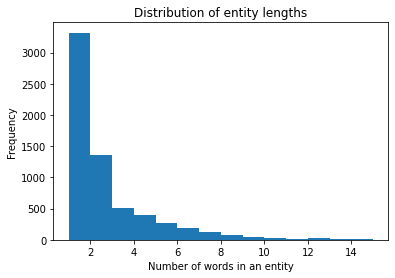

In [ ]:
max_len_train = ann_statistics(ann_train)


**Statistics of the .ann development files**

In [ ]:
max_len_dev = ann_statistics(ann_dev)

NameError: ignored

**Statistics of the .ann test files**


Maximum entity length: 25

Annotation file with maximum entity length: 134

Entity position in the file: 10

Entity: ['T11', 'MORFOLOGIA_NEOPLASIA 3701 3878', 'carcinoma indiferenciado de células pequeñas combinado con carcinoma papilar de células transicionales de alto grado y metaplasia intestinal con focos de displasia de alto grado\n']

Average entity length: 2


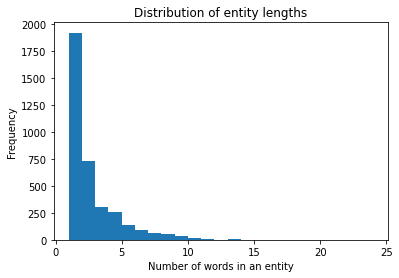

In [ ]:
max_len_test_true = ann_statistics(ann_test_true)

#### **Extracting the entities from the .ann file**


In [ ]:
# ann_train[i][1]: contains both the entity type and position in the text
print(ann_train[0][1])

In [ ]:
def extract_entity_info(ann):  
  e_type = []
  start_End_offset = []
  start_End_offset2 = []
  entity_length = []

  for i in range(len(ann)): # loop over every annotated file
    a_i = ann[i]
    for j in range(len(a_i)): # loop over the lines at each annotated file
      e_type.append(a_i[j][1].strip(" 0123456789;")) # To obtain the entity 
      
      # obtaining the start char position by removing the entities found above
      start_char = a_i[j][1].strip(str(e_type[j]))
      start_End_offset.append(start_char) 

      # Creating the Start_End offsets of entities formed by various words
      s_E_offset_split = start_char.split(" ")[1] 
      #  splits ' 4603 4636' into three elements ['', '4603', '4636'], we are interested in element [1]

      # Processing the third element in ['T2', 'MORFOLOGIA_NEOPLASIA 10370 10379', 'neoplasia\n']
      entity_words = ann[i][j][2].split(" ") # splitting the entity into words

      start_End = []
      len_words = 0

      for wi in range(len(entity_words)):
        if wi == 0: # if it's the first word in the entity
          start_End.append(s_E_offset_split + " " + str(int(s_E_offset_split)+len(entity_words[wi])-1))
        else:
          start_End.append(str(int(s_E_offset_split) + len_words) + " " + str(int(s_E_offset_split) + len_words + len(entity_words[wi])-1))

        len_words = len_words + len(entity_words[wi]) + 1 # this plus 1 are the spaces

      start_End = ';'.join(start_End) # combining the elements in start_End into a single string
      # ex. ['4207;4212', '4214;4223'] into 4207;4212 4214;4223
      start_End_offset2.append(start_End)
      entity_length.append(len(entity_words))

  e_types = np.unique(e_type)
  print(e_types) 

  return start_End_offset2, e_type, entity_length

#### **Create a dataframe with the entity information**


In [ ]:
def create_entity_df(ann, start_End_offset2, e_type):
  df_ann = pd.DataFrame(columns = ["File_Index", "Entity_ID", "Type Start_End_offset", "Entity"])

  for i in range(len(ann)):
    # Appending the index file to each line in the annotated files
    ann2 = [np.hstack(("File: "+str(i+1),ann[i][j])) for j in range(len(ann[i]))]

    df = pd.DataFrame(ann2, columns = ["File_Index", "Entity_ID", "Type Start_End_offset", "Entity"])

    df_ann = df_ann.append(df)

  # We want to create a dataframe with the entity information:
  df_ann['Type'] = e_type
  # df_ann['Start_End_offset'] = start_End_offset # keep this to check 
  df_ann['Start_End_offset'] = start_End_offset2

  df_ann = df_ann.drop(['Type Start_End_offset'], axis=1)

  new_order = [0, 1, 3, 4, 2]
  df_ann = df_ann[df_ann.columns[new_order]]

  return df_ann

**Train set**

In [ ]:
start_End_offset2_train, e_type_train, entity_length_train = extract_entity_info(ann_train)
df_ann_train = create_entity_df(ann_train, start_End_offset2_train, e_type_train)
df_ann_train

['MORFOLOGIA_NEOPLASIA']


,File_Index,Entity_ID,Type,Start_End_offset,Entity
0,File: 1,T1,MORFOLOGIA_NEOPLASIA,2719 2727;2729 2740,Carcinoma microcítico\n
1,File: 1,T2,MORFOLOGIA_NEOPLASIA,2950 2958;2960 2971,carcinoma microcítico\n
2,File: 1,T3,MORFOLOGIA_NEOPLASIA,2988 2990,M0\n
0,File: 2,T1,MORFOLOGIA_NEOPLASIA,6833 6844,metastásica\n
1,File: 2,T2,MORFOLOGIA_NEOPLASIA,1191 1201,metástasis\n
...,...,...,...,...,...
11,File: 501,T12,MORFOLOGIA_NEOPLASIA,379 392,paraganglioma\n
12,File: 501,T13,MORFOLOGIA_NEOPLASIA,1070 1083,paraganglioma\n
13,File: 501,T14,MORFOLOGIA_NEOPLASIA,1677 1690,paraganglioma\n
14,File: 501,T15,MORFOLOGIA_NEOPLASIA,1611 1621,tumoración\n


In [ ]:
# Check for null values:
df_ann_train.isnull().sum()

File_Index          0
Entity_ID           0
Type                0
Start_End_offset    0
Entity              0
dtype: int64

**Development set**

In [ ]:
start_End_offset2_dev, e_type_dev, entity_length_dev = extract_entity_info(ann_dev)
df_ann_dev = create_entity_df(ann_dev, start_End_offset2_dev, e_type_dev)
df_ann_dev

['MORFOLOGIA_NEOPLASIA']


,File_Index,Entity_ID,Type,Start_End_offset,Entity
0,File: 1,T1,MORFOLOGIA_NEOPLASIA,2428 2435;2437 2445,lesiones cutáneas\n
1,File: 1,T2,MORFOLOGIA_NEOPLASIA,994 1001;1003 1016;1018 1019;1021 1022;1024 1030,lesiones osteoblásticas en la calota\n
2,File: 1,T3,MORFOLOGIA_NEOPLASIA,1700 1707;1709 1719,lesiones pulmonares\n
3,File: 1,T4,MORFOLOGIA_NEOPLASIA,1253 1258;1260 1267,lesión cutánea\n
4,File: 1,T5,MORFOLOGIA_NEOPLASIA,273 284,metastásica\n
...,...,...,...,...,...
19,File: 250,T20,MORFOLOGIA_NEOPLASIA,2774 2787;2789 2796;2798 2800;2802 2811,adenocarcinoma gástrico rIV (PULMONAR\n
20,File: 250,T21,MORFOLOGIA_NEOPLASIA,4438 4447;4449 4449;4451 4455;4457 4467,progresión a nivel peritoneal\n
21,File: 250,T22,MORFOLOGIA_NEOPLASIA,4471 4478;4480 4492,implante rectovesical\n
22,File: 250,T23,MORFOLOGIA_NEOPLASIA,5352 5360;5362 5363;5365 5368;5370 5377;5379 5...,implantes en cara anterior de recto\n


In [ ]:
# Check for null values:
df_ann_dev.isnull().sum()

File_Index          0
Entity_ID           0
Type                0
Start_End_offset    0
Entity              0
dtype: int64

In [ ]:
#print(ann[0][0][2])
#entity_words[0]

**Test with gold standards set**

In [ ]:
start_End_offset2_test, e_type_test, entity_length_test = extract_entity_info(ann_test_true)
df_ann_test_true = create_entity_df(ann_test_true, start_End_offset2_test, e_type_test)
df_ann_test_true

['MORFOLOGIA_NEOPLASIA']


,File_Index,Entity_ID,Type,Start_End_offset,Entity
0,File: 1,T1,MORFOLOGIA_NEOPLASIA,2810 2824,adenocarcinoma\n
1,File: 1,T2,MORFOLOGIA_NEOPLASIA,2979 2993,adenocarcinoma\n
2,File: 1,T3,MORFOLOGIA_NEOPLASIA,1115 1128;1130 1133;1135 1147,adenocarcinoma bien diferenciado\n
3,File: 1,T4,MORFOLOGIA_NEOPLASIA,1911 1924;1926 1929;1931 1943,adenocarcinoma bien diferenciado\n
4,File: 1,T5,MORFOLOGIA_NEOPLASIA,4046 4055;4057 4072,adenopatía supraclavicular\n
...,...,...,...,...,...
8,File: 300,T9,MORFOLOGIA_NEOPLASIA,1464 1474,metástasis\n
9,File: 300,T10,MORFOLOGIA_NEOPLASIA,677 684,tumoral\n
10,File: 300,T11,MORFOLOGIA_NEOPLASIA,1098 1105,tumoral\n
11,File: 300,T12,MORFOLOGIA_NEOPLASIA,1912 1915,CMm\n


In [ ]:
# Check for null values:
df_ann_test_true.isnull().sum()

File_Index          0
Entity_ID           0
Type                0
Start_End_offset    0
Entity              0
dtype: int64

**The labels of this dataset are:**

['MORFOLOGIA_NEOPLASIA']

Therefore, to construct the BIO format for this specific problem, the tags that will be employed are:
- 'O': if the word is not an entity
- 'B-MOR': if the word is at the beginning of a ['MORFOLOGIA_NEOPLASIA'] entity
- 'I-MOR': if the word is intermediate to a ['MORFOLOGIA_NEOPLASIA'] entity


In [ ]:
def splitting(d,i):
  if len(d)>=i+1: 
    new_start = d[i].split(" ")[0]
  else: 
    new_start = -1 # to state the is no entity 
  return new_start

In [ ]:
def create_tags(df_ann, max_len, entity_length): # receives the dataframe with the annotations
  # creating a tag to paste into the df_ann
  df_ann['Tag'] = ""
  df_ann['Tag'] = "B-" + df_ann['Type'].apply(lambda d: d[:3])# selecting just the first 3 characters in 'Type'
  #df_ann['Start_Char_position'] = df_ann['Start_End_offset'].apply(lambda d: d.split(" ")[0])
  print(df_ann.head(10))
  print()
  df_ann['Entity_length'] = entity_length

  # Creating a column for every pair of start_end of entities --> for those entities formed by more than one word
  df_ann['Start_End_offset'] = df_ann['Start_End_offset'].apply(lambda d: d.split(";"))

  for i in range(max_len): # the maximum number of words in an entity is 16
    col_name = 'Start_Char_position_'+str(i)
    df_ann[col_name] = df_ann['Start_End_offset'].apply(lambda d: splitting(d, i))
    df_ann[col_name] = df_ann[col_name].astype(int)

  #df_ann.loc[[4056]] # this is the entity formed by the largest number of words. (9 words)
  return df_ann

**Creating tags on train set**

In [ ]:
df_ann_train = create_tags(df_ann_train, max_len_train, entity_length_train)
df_ann_train.head(5)

NameError: ignored

**Creating tags on development set**

In [ ]:
df_ann_dev = create_tags(df_ann_dev, max_len_dev, entity_length_dev)
df_ann_dev.head(5)

  File_Index  ...    Tag
0    File: 1  ...  B-MOR
1    File: 1  ...  B-MOR
2    File: 1  ...  B-MOR
3    File: 1  ...  B-MOR
4    File: 1  ...  B-MOR
5    File: 1  ...  B-MOR
6    File: 1  ...  B-MOR
7    File: 1  ...  B-MOR
8    File: 1  ...  B-MOR
9    File: 1  ...  B-MOR

[10 rows x 6 columns]



,File_Index,Entity_ID,Type,Start_End_offset,Entity,Tag,Entity_length,Start_Char_position_0,Start_Char_position_1,Start_Char_position_2,Start_Char_position_3,Start_Char_position_4,Start_Char_position_5,Start_Char_position_6,Start_Char_position_7,Start_Char_position_8,Start_Char_position_9,Start_Char_position_10,Start_Char_position_11,Start_Char_position_12,Start_Char_position_13,Start_Char_position_14,Start_Char_position_15,Start_Char_position_16
0,File: 1,T1,MORFOLOGIA_NEOPLASIA,"[2428 2435, 2437 2445]",lesiones cutáneas\n,B-MOR,2,2428,2437,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,File: 1,T2,MORFOLOGIA_NEOPLASIA,"[994 1001, 1003 1016, 1018 1019, 1021 1022, 10...",lesiones osteoblásticas en la calota\n,B-MOR,5,994,1003,1018,1021,1024,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,File: 1,T3,MORFOLOGIA_NEOPLASIA,"[1700 1707, 1709 1719]",lesiones pulmonares\n,B-MOR,2,1700,1709,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,File: 1,T4,MORFOLOGIA_NEOPLASIA,"[1253 1258, 1260 1267]",lesión cutánea\n,B-MOR,2,1253,1260,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,File: 1,T5,MORFOLOGIA_NEOPLASIA,[273 284],metastásica\n,B-MOR,1,273,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


**Creating tags in the test set**

In [ ]:
df_ann_test_true = create_tags(df_ann_test_true, max_len_test_true, entity_length_test)
df_ann_test_true.head(5)

  File_Index Entity_ID  ...                              Entity    Tag
0    File: 1        T1  ...                    adenocarcinoma\n  B-MOR
1    File: 1        T2  ...                    adenocarcinoma\n  B-MOR
2    File: 1        T3  ...  adenocarcinoma bien diferenciado\n  B-MOR
3    File: 1        T4  ...  adenocarcinoma bien diferenciado\n  B-MOR
4    File: 1        T5  ...        adenopatía supraclavicular\n  B-MOR
5    File: 1        T6  ...               afectación hepática\n  B-MOR
6    File: 1        T7  ...                lesiones hepáticas\n  B-MOR
7    File: 1        T8  ...                      metastásicas\n  B-MOR
8    File: 1        T9  ...                      metastásicas\n  B-MOR
9    File: 1       T10  ...                        metástasis\n  B-MOR

[10 rows x 6 columns]



,File_Index,Entity_ID,Type,Start_End_offset,Entity,Tag,Entity_length,Start_Char_position_0,Start_Char_position_1,Start_Char_position_2,Start_Char_position_3,Start_Char_position_4,Start_Char_position_5,Start_Char_position_6,Start_Char_position_7,Start_Char_position_8,Start_Char_position_9,Start_Char_position_10,Start_Char_position_11,Start_Char_position_12,Start_Char_position_13,Start_Char_position_14,Start_Char_position_15,Start_Char_position_16,Start_Char_position_17,Start_Char_position_18,Start_Char_position_19,Start_Char_position_20,Start_Char_position_21,Start_Char_position_22,Start_Char_position_23,Start_Char_position_24
0,File: 1,T1,MORFOLOGIA_NEOPLASIA,[2810 2824],adenocarcinoma\n,B-MOR,1,2810,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,File: 1,T2,MORFOLOGIA_NEOPLASIA,[2979 2993],adenocarcinoma\n,B-MOR,1,2979,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,File: 1,T3,MORFOLOGIA_NEOPLASIA,"[1115 1128, 1130 1133, 1135 1147]",adenocarcinoma bien diferenciado\n,B-MOR,3,1115,1130,1135,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,File: 1,T4,MORFOLOGIA_NEOPLASIA,"[1911 1924, 1926 1929, 1931 1943]",adenocarcinoma bien diferenciado\n,B-MOR,3,1911,1926,1931,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,File: 1,T5,MORFOLOGIA_NEOPLASIA,"[4046 4055, 4057 4072]",adenopatía supraclavicular\n,B-MOR,2,4046,4057,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


### **Combining text files and annotated files**

**Find those words in df_data which are an entity based on the position of their first character**

This is done by merging the dataframe with the txt content (df_data) with the information collected from the annotated file (df_ann).

In [ ]:
# code to replace "B-" by "I-" for entities with various words
def turn_to_Intermediate(d, i):
  if str(d)!='nan': 
    new_tag = "I-" + str(d)[2:]
  else: 
    new_tag = d # to state the is no entity 
  return new_tag

In [ ]:
def turn_to_IOBES(d, i):
  if str(d)!='nan': 
    if i > 0:
      if d == i+1:# end
        new_tag = "E-MOR"
      else:
        new_tag = "I-MOR"
    else:
      if d == 1: # single word entity
        new_tag = "S-MOR"
      else:
        new_tag = "B-MOR"

  else:
    new_tag = d #nan
  return new_tag

In [ ]:
def combine_txt_ann(df_ann, df_data, max_len):
  # 1st. LEFT JOIN 
  # This code performs a left join between the df_data and df_ann to paste the Tag of each entity based on the character positions
  for i in range(max_len):
    col_name = 'Start_Char_position_'+str(i)
    df_data = df_data.merge(df_ann[['File_Index',col_name,'Tag', 'Entity_length']], how = 'left', left_on=['File_Index','Start_Char_position'], right_on=['File_Index',col_name], suffixes=('','_'+str(i)))
    # selecting the columns col_name and 'Tag' from df_ann

    # drop intermediary columns 'Start_Char_position'
    df_data = df_data.drop([col_name], axis=1)

    if i>0: # code to replace "B-" by "I-" for entities with various words
      col_name2 = 'Tag_'+str(i)
      col_name3 = 'Entity_length_'+str(i)
    else:
      col_name2 = 'Tag'
      col_name3 = 'Entity_length'

    #df_data[col_name2] = df_data[col_name2].apply(lambda d: turn_to_Intermediate(d,i))
    df_data[col_name2] = df_data[col_name3].apply(lambda d: turn_to_IOBES(d,i)) # to apply over each row
 
  print(df_data.head(5))

  # drop columns Entity_length
  df_data = df_data.drop(['Entity_length'], axis=1)

  for i in range(1,max_len): # max(entity_lengths) is the maximum number of words forming an entity
    col_name = 'Entity_length_'+str(i)
    df_data = df_data.drop([col_name], axis=1)

  # 2nd. COMBINE INFORMATION FROM THE 'TAG' COLUMNS
  df_data['Tag_new'] = ""
  df_data['Tag_new'] = df_data[df_data.columns[5:]].apply(lambda x: ''.join(x.dropna().astype(str)),axis=1)

  # Drop unneeded columns
  df_data = df_data.drop(['Tag'], axis=1)
  #df_data = df_data.drop(['Start_Char_position'], axis=1)

  for i in range(1,max_len): # max(entity_lengths) is the maximum number of words forming an entity
    col_name = 'Tag_'+str(i)
    df_data = df_data.drop([col_name], axis=1)

  # Rename column 'Tag_new' to 'Tag'
  df_data.columns = ["File_Index","Sentence_Index", "Word", "POS","start", "Tag"]

  # Fill in the empty rows of column 'Tag' with label 'O'
  df_data['Tag'].replace("", "O", inplace= True)

  return df_data


### **Nested Entities:**

**problem: there are entities of the same ann file that appear in various annotations. NESTED ENTITIES**

The are two options to deal with nested entities:

- Option 1. Keep the longest entity. Does not seem adequate. 
- Option 2. Use a new format different to BIO --> BIOES-V. where V indicates nested entities

In [ ]:
# code to replace "B-MORI-MOR" by "B-MOR", 'I-MORI-MOR' by 'I-MOR' and 'I-MORB-MOR' by "B-MOR"
def correct_tag(d):
  if len(str(d)) > 5: # longer than 'B-MOR'
    tag = "V-MOR"
  else:
    tag = str(d) # return its original value
  return tag

In [ ]:
df_data_train2 = df_data_train.copy()
df_data_dev2 = df_data_dev.copy()

In [ ]:
# test with gold standards
df_data_test_true2 = df_data_test_true.copy()

**Train set**

In [ ]:
df_data_train2 = combine_txt_ann(df_ann_train, df_data_train2, max_len_train )
print(df_data_train2['Tag'].unique())

# replace nested entities
df_data_train2['Tag'] = df_data_train2['Tag'].apply(lambda d: correct_tag(d))

  File_Index Sentence_Index  ... Tag_15 Entity_length_15
0    File: 1    Sentence: 1  ...    NaN              NaN
1    File: 1    Sentence: 1  ...    NaN              NaN
2    File: 1    Sentence: 1  ...    NaN              NaN
3    File: 1    Sentence: 1  ...    NaN              NaN
4    File: 1    Sentence: 1  ...    NaN              NaN

[5 rows x 37 columns]
['O' 'B-MOR' 'E-MOR' 'S-MOR' 'I-MOR' 'B-MORI-MOR' 'I-MORI-MOR'
 'E-MORI-MOR' 'E-MORE-MOR' 'S-MORI-MOR']


In [ ]:
df_data_train2.head(5)

,File_Index,Sentence_Index,Word,POS,start,Tag
0,File: 1,Sentence: 1,ANAMNESIS,NOUN,0,O
1,File: 1,Sentence: 1,\n,SPACE,9,O
2,File: 1,Sentence: 1,Mujer,NOUN,10,O
3,File: 1,Sentence: 1,de,ADP,16,O
4,File: 1,Sentence: 1,67,NUM,19,O


In [ ]:
df_data_train2[df_data_train2['Tag']!='O']

,File_Index,Sentence_Index,Word,POS,start,Tag
425,File: 1,Sentence: 20,Carcinoma,PROPN,2719,B-MOR
426,File: 1,Sentence: 20,microcítico,ADJ,2729,E-MOR
460,File: 1,Sentence: 22,carcinoma,INTJ,2950,B-MOR
461,File: 1,Sentence: 22,microcítico,ADJ,2960,E-MOR
465,File: 1,Sentence: 22,M0,PROPN,2988,S-MOR
...,...,...,...,...,...,...
453833,File: 501,Sentence: 19484,ósea,ADJ,3909,E-MOR
453858,File: 501,Sentence: 19485,afectación,NOUN,4054,B-MOR
453859,File: 501,Sentence: 19485,ósea,ADJ,4065,E-MOR
453879,File: 501,Sentence: 19487,Paraganglioma,PROPN,4157,S-MOR


In [ ]:
num_BMOR_train = len(df_data_train2[df_data_train2['Tag']=='B-MOR'])
num_IMOR_train = len(df_data_train2[df_data_train2['Tag']=='I-MOR'])
num_EMOR_train = len(df_data_train2[df_data_train2['Tag']=='E-MOR'])
num_SMOR_train = len(df_data_train2[df_data_train2['Tag']=='S-MOR'])
num_VMOR_train = len(df_data_train2[df_data_train2['Tag']=='V-MOR'])

num_O_train = len(df_data_train2[df_data_train2['Tag']=='O'])

print("Number of B-MOR entities: %d" %num_BMOR_train)
print("Number of I-MOR entities: %d" %num_IMOR_train)
print("Number of E-MOR entities: %d" %num_EMOR_train)
print("Number of S-MOR entities: %d" %num_SMOR_train)
print("Number of V-MOR entities: %d" %num_VMOR_train)
print("Number of O (non entity): %d" %num_O_train)

print("\nTotal number of identified entity words: %d" %(num_BMOR_train + num_IMOR_train + num_EMOR_train + num_SMOR_train + num_VMOR_train))

print("\nTotal number of words that conform annotated entities: %d" %np.sum(entity_length_train))

print("\nTotal number of words (entities and non-entities): %d" %len(df_data_train2))
print("\nTotal number of words (entities and non-entities): %d" %(num_BMOR_train + num_IMOR_train + 
                                                                  num_EMOR_train + num_SMOR_train + num_VMOR_train + num_O_train))

Number of B-MOR entities: 3071
Number of I-MOR entities: 5193
Number of E-MOR entities: 3070
Number of S-MOR entities: 3313
Number of V-MOR entities: 20
Number of O (non entity): 439863
Nested train: 0

Total number of identified entity words: 14667

Total number of words that conform annotated entities: 14694

Total number of words (entities and non-entities): 454530

Total number of words (entities and non-entities): 454530


**Development set**

In [ ]:
df_data_dev2 = combine_txt_ann(df_ann_dev, df_data_dev2, max_len_dev)
print(df_data_dev2['Tag'].unique())

# replace nested entities
df_data_dev2['Tag'] = df_data_dev2['Tag'].apply(lambda d: correct_tag(d))

  File_Index Sentence_Index  ... Tag_16 Entity_length_16
0    File: 1    Sentence: 1  ...    NaN              NaN
1    File: 1    Sentence: 1  ...    NaN              NaN
2    File: 1    Sentence: 1  ...    NaN              NaN
3    File: 1    Sentence: 1  ...    NaN              NaN
4    File: 1    Sentence: 1  ...    NaN              NaN

[5 rows x 39 columns]
['O' 'B-MOR' 'I-MOR' 'E-MOR' 'S-MOR' 'B-MORI-MOR' 'E-MORE-MOR'
 'S-MORI-MOR' 'I-MORI-MOR' 'I-MORE-MOR' 'E-MORI-MOR' 'B-MORE-MOR']


In [ ]:
df_data_dev2.head(5)

,File_Index,Sentence_Index,Word,POS,start,Tag
0,File: 1,Sentence: 1,Anamnesis,NOUN,0,O
1,File: 1,Sentence: 1,\n,SPACE,9,O
2,File: 1,Sentence: 1,Varón,PROPN,10,O
3,File: 1,Sentence: 1,de,ADP,16,O
4,File: 1,Sentence: 1,74,NUM,19,O


In [ ]:
num_BMOR_dev = len(df_data_dev2[df_data_dev2['Tag']=='B-MOR'])
num_IMOR_dev = len(df_data_dev2[df_data_dev2['Tag']=='I-MOR'])
num_EMOR_dev = len(df_data_dev2[df_data_dev2['Tag']=='E-MOR'])
num_SMOR_dev = len(df_data_dev2[df_data_dev2['Tag']=='S-MOR'])
num_VMOR_dev = len(df_data_dev2[df_data_dev2['Tag']=='V-MOR'])

num_O_dev = len(df_data_dev2[df_data_dev2['Tag']=='O'])

print("Number of B-MOR entities: %d" %num_BMOR_dev)
print("Number of I-MOR entities: %d" %num_IMOR_dev)
print("Number of E-MOR entities: %d" %num_EMOR_dev)
print("Number of S-MOR entities: %d" %num_SMOR_dev)
print("Number of V-MOR entities: %d" %num_VMOR_dev)
print("Number of O (non entity): %d" %num_O_dev)

print("\nTotal number of identified entity words: %d" %(num_BMOR_dev + num_IMOR_dev + num_EMOR_dev + num_SMOR_dev + num_VMOR_dev))

print("\nTotal number of words that conform annotated entities: %d" %np.sum(entity_length_dev))

print("\nTotal number of words (entities and non-entities): %d" %len(df_data_dev2))
print("\nTotal number of words (entities and non-entities): %d" %(num_BMOR_dev + num_IMOR_dev + 
                                                                  num_EMOR_dev + num_SMOR_dev + num_VMOR_dev + num_O_dev))

Number of B-MOR entities: 1639
Number of I-MOR entities: 2579
Number of E-MOR entities: 1634
Number of S-MOR entities: 1689
Number of V-MOR entities: 18
Number of O (non entity): 217845
Nested train: 0

Total number of identified entity words: 7559

Total number of words that conform annotated entities: 7582

Total number of words (entities and non-entities): 225404

Total number of words (entities and non-entities): 225404


In [ ]:
# Checking:
#file1_final = df_data2[df_data2['File_Index']=="File: 2"][df_data2['Tag']!="O"]
#file1_final

**Test with gold standards set**

In [ ]:
df_data_test_true2 = combine_txt_ann(df_ann_test_true, df_data_test_true2, max_len_test_true)
print(df_data_test_true2['Tag'].unique())

# replace nested entities
df_data_test_true2['Tag'] = df_data_test_true2['Tag'].apply(lambda d: correct_tag(d))

  File_Index Sentence_Index  ... Tag_24 Entity_length_24
0    File: 1    Sentence: 1  ...    NaN              NaN
1    File: 1    Sentence: 1  ...    NaN              NaN
2    File: 1    Sentence: 1  ...    NaN              NaN
3    File: 1    Sentence: 1  ...    NaN              NaN
4    File: 1    Sentence: 1  ...    NaN              NaN

[5 rows x 55 columns]
['O' 'S-MOR' 'B-MOR' 'I-MOR' 'E-MOR' 'S-MORE-MOR' 'S-MORI-MOR'
 'B-MORI-MOR' 'I-MORI-MOR' 'E-MORI-MOR' 'E-MORE-MOR']


In [ ]:
print(df_data_test_true2['Tag'].unique())

['O' 'S-MOR' 'B-MOR' 'I-MOR' 'E-MOR' 'V-MOR']


In [ ]:
df_data_test_true2.head(5)

,File_Index,Sentence_Index,Word,POS,start,Tag
0,File: 1,Sentence: 1,Anamnesis,NOUN,0,O
1,File: 1,Sentence: 1,\n,SPACE,9,O
2,File: 1,Sentence: 1,Se,PRON,10,O
3,File: 1,Sentence: 1,trata,VERB,13,O
4,File: 1,Sentence: 1,de,ADP,19,O


In [ ]:
num_BMOR_test = len(df_data_test_true2[df_data_test_true2['Tag']=='B-MOR'])
num_IMOR_test = len(df_data_test_true2[df_data_test_true2['Tag']=='I-MOR'])
num_EMOR_test = len(df_data_test_true2[df_data_test_true2['Tag']=='E-MOR'])
num_SMOR_test = len(df_data_test_true2[df_data_test_true2['Tag']=='S-MOR'])
num_VMOR_test = len(df_data_test_true2[df_data_test_true2['Tag']=='V-MOR'])

num_O_test = len(df_data_test_true2[df_data_test_true2['Tag']=='O'])

print("Number of B-MOR entities: %d" %num_BMOR_test)
print("Number of I-MOR entities: %d" %num_IMOR_test)
print("Number of E-MOR entities: %d" %num_EMOR_test)
print("Number of S-MOR entities: %d" %num_SMOR_test)
print("Number of V-MOR entities: %d" %num_VMOR_test)
print("Number of O (non entity): %d" %num_O_test)


print("\nTotal number of identified entity words: %d" %(num_BMOR_test + num_IMOR_test + num_EMOR_test + num_SMOR_test + num_VMOR_test))

print("\nTotal number of words that conform annotated entities: %d" %np.sum(entity_length_test))

print("\nTotal number of words (entities and non-entities): %d" %len(df_data_test_true2))
print("\nTotal number of words (entities and non-entities): %d" %(num_BMOR_test + num_IMOR_test + 
                                                                  num_EMOR_test + num_SMOR_test + num_VMOR_test + num_O_test))

Number of B-MOR entities: 1709
Number of I-MOR entities: 2791
Number of E-MOR entities: 1707
Number of S-MOR entities: 1908
Number of V-MOR entities: 22
Number of O (non entity): 239701

Total number of identified entity words: 8137

Total number of words that conform annotated entities: 8165

Total number of words (entities and non-entities): 247838

Total number of words (entities and non-entities): 247838


**Now, the dataframes to work with are:**

**Train set:**
- df_data_train2
- df_ann_train

**Development set**
- df_data_dev2
- df_ann_dev

In [ ]:
df_ann_dev

,File_Index,Entity_ID,Type,Start_End_offset,Entity,Tag,Entity_length,Start_Char_position_0,Start_Char_position_1,Start_Char_position_2,Start_Char_position_3,Start_Char_position_4,Start_Char_position_5,Start_Char_position_6,Start_Char_position_7,Start_Char_position_8,Start_Char_position_9,Start_Char_position_10,Start_Char_position_11,Start_Char_position_12,Start_Char_position_13,Start_Char_position_14,Start_Char_position_15,Start_Char_position_16
0,File: 1,T1,MORFOLOGIA_NEOPLASIA,"[2428 2435, 2437 2445]",lesiones cutáneas\n,B-MOR,2,2428,2437,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,File: 1,T2,MORFOLOGIA_NEOPLASIA,"[994 1001, 1003 1016, 1018 1019, 1021 1022, 10...",lesiones osteoblásticas en la calota\n,B-MOR,5,994,1003,1018,1021,1024,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,File: 1,T3,MORFOLOGIA_NEOPLASIA,"[1700 1707, 1709 1719]",lesiones pulmonares\n,B-MOR,2,1700,1709,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,File: 1,T4,MORFOLOGIA_NEOPLASIA,"[1253 1258, 1260 1267]",lesión cutánea\n,B-MOR,2,1253,1260,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,File: 1,T5,MORFOLOGIA_NEOPLASIA,[273 284],metastásica\n,B-MOR,1,273,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,File: 250,T20,MORFOLOGIA_NEOPLASIA,"[2774 2787, 2789 2796, 2798 2800, 2802 2811]",adenocarcinoma gástrico rIV (PULMONAR\n,B-MOR,4,2774,2789,2798,2802,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
20,File: 250,T21,MORFOLOGIA_NEOPLASIA,"[4438 4447, 4449 4449, 4451 4455, 4457 4467]",progresión a nivel peritoneal\n,B-MOR,4,4438,4449,4451,4457,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21,File: 250,T22,MORFOLOGIA_NEOPLASIA,"[4471 4478, 4480 4492]",implante rectovesical\n,B-MOR,2,4471,4480,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
22,File: 250,T23,MORFOLOGIA_NEOPLASIA,"[5352 5360, 5362 5363, 5365 5368, 5370 5377, 5...",implantes en cara anterior de recto\n,B-MOR,6,5352,5362,5365,5370,5379,5382,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [ ]:
# We just want to keep the first 5 columns of df_ann

# Train set
col_names = df_ann_train.columns[6:]
for name in col_names:
  df_ann_train = df_ann_train.drop([name], axis=1)

# Development set
col_names = df_ann_dev.columns[6:]
for name in col_names:
  df_ann_dev = df_ann_dev.drop([name], axis=1)

In [ ]:
# Test set with gold standards
col_names = df_ann_test_true.columns[6:]
for name in col_names:
  df_ann_test_true = df_ann_test_true.drop([name], axis=1)

In [ ]:
df_ann_train.head(10)

,File_Index,Entity_ID,Type,Start_End_offset,Entity,Tag
0,File: 1,T1,MORFOLOGIA_NEOPLASIA,"[2719 2727, 2729 2740]",Carcinoma microcítico\n,B-MOR
1,File: 1,T2,MORFOLOGIA_NEOPLASIA,"[2950 2958, 2960 2971]",carcinoma microcítico\n,B-MOR
2,File: 1,T3,MORFOLOGIA_NEOPLASIA,[2988 2990],M0\n,B-MOR
0,File: 2,T1,MORFOLOGIA_NEOPLASIA,[6833 6844],metastásica\n,B-MOR
1,File: 2,T2,MORFOLOGIA_NEOPLASIA,[1191 1201],metástasis\n,B-MOR
2,File: 2,T3,MORFOLOGIA_NEOPLASIA,[2039 2049],metástasis\n,B-MOR
3,File: 2,T4,MORFOLOGIA_NEOPLASIA,[976 985],neoplasia\n,B-MOR
4,File: 2,T5,MORFOLOGIA_NEOPLASIA,[2666 2675],neoplasia\n,B-MOR
5,File: 2,T6,MORFOLOGIA_NEOPLASIA,[212 217],tumor\n,B-MOR
6,File: 2,T7,MORFOLOGIA_NEOPLASIA,[7122 7132],tumoración\n,B-MOR


In [ ]:
df_ann_test_true.head(10)

,File_Index,Entity_ID,Type,Start_End_offset,Entity,Tag
0,File: 1,T1,MORFOLOGIA_NEOPLASIA,[2810 2824],adenocarcinoma\n,B-MOR
1,File: 1,T2,MORFOLOGIA_NEOPLASIA,[2979 2993],adenocarcinoma\n,B-MOR
2,File: 1,T3,MORFOLOGIA_NEOPLASIA,"[1115 1128, 1130 1133, 1135 1147]",adenocarcinoma bien diferenciado\n,B-MOR
3,File: 1,T4,MORFOLOGIA_NEOPLASIA,"[1911 1924, 1926 1929, 1931 1943]",adenocarcinoma bien diferenciado\n,B-MOR
4,File: 1,T5,MORFOLOGIA_NEOPLASIA,"[4046 4055, 4057 4072]",adenopatía supraclavicular\n,B-MOR
5,File: 1,T6,MORFOLOGIA_NEOPLASIA,"[2172 2181, 2183 2191]",afectación hepática\n,B-MOR
6,File: 1,T7,MORFOLOGIA_NEOPLASIA,"[3531 3538, 3540 3549]",lesiones hepáticas\n,B-MOR
7,File: 1,T8,MORFOLOGIA_NEOPLASIA,[882 894],metastásicas\n,B-MOR
8,File: 1,T9,MORFOLOGIA_NEOPLASIA,[1678 1690],metastásicas\n,B-MOR
9,File: 1,T10,MORFOLOGIA_NEOPLASIA,[2494 2504],metástasis\n,B-MOR


In [ ]:
df_data_test_true2

,File_Index,Sentence_Index,Word,POS,start,Tag
0,File: 1,Sentence: 1,Anamnesis,NOUN,0,O
1,File: 1,Sentence: 1,\n,SPACE,9,O
2,File: 1,Sentence: 1,Se,PRON,10,O
3,File: 1,Sentence: 1,trata,VERB,13,O
4,File: 1,Sentence: 1,de,ADP,19,O
...,...,...,...,...,...,...
247833,File: 300,Sentence: 11235,433,NUM,6226,O
247834,File: 300,Sentence: 11235,U,PROPN,6230,O
247835,File: 300,Sentence: 11235,/,PUNCT,6231,O
247836,File: 300,Sentence: 11235,ml,NOUN,6232,O


In [ ]:
df_data_test_true2 = df_data_test_true2.drop_duplicates(['File_Index','Sentence_Index','start'], keep = 'first')


In [ ]:
df_data_test_true2

,File_Index,Sentence_Index,Word,POS,start,Tag
0,File: 1,Sentence: 1,Anamnesis,NOUN,0,O
1,File: 1,Sentence: 1,\n,SPACE,9,O
2,File: 1,Sentence: 1,Se,PRON,10,O
3,File: 1,Sentence: 1,trata,VERB,13,O
4,File: 1,Sentence: 1,de,ADP,19,O
...,...,...,...,...,...,...
247833,File: 300,Sentence: 11235,433,NUM,6226,O
247834,File: 300,Sentence: 11235,U,PROPN,6230,O
247835,File: 300,Sentence: 11235,/,PUNCT,6231,O
247836,File: 300,Sentence: 11235,ml,NOUN,6232,O


### **PREPROCESSING**

In [ ]:
# This is a class to get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t, i) for w, p, t, i in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist(),
                                                       s['start'].values.tolist())]
        self.grouped = self.df.groupby("Sentence_Index").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [ ]:
# This is a class to get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence_test(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, i) for w, p, i in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Start_Char_position'].values.tolist())]
        self.grouped = self.df.groupby("Sentence_Index").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [ ]:
df_data_train2copy = df_data_train2.copy()
df_data_dev2copy = df_data_dev2.copy()
df_data_testcopy = df_data_test.copy()

In [ ]:
df_data_test_true2copy = df_data_test_true2.copy()

In [ ]:
# Turn "Sentence: 1" to 1 and "File: 1" to 1
df_data_train2['Sentence_Index'] = df_data_train2['Sentence_Index'].map(lambda d: d[10:])
df_data_train2['Sentence_Index'] = df_data_train2['Sentence_Index'].astype(np.long)
df_data_train2['File_Index'] = df_data_train2['File_Index'].map(lambda d: d[6:])
df_data_train2['File_Index'] = df_data_train2['File_Index'].astype(np.long)

# Turn "Sentence: 1" to 1 and "File: 1" to 1
df_data_dev2['Sentence_Index'] = df_data_dev2['Sentence_Index'].map(lambda d: d[10:])
df_data_dev2['Sentence_Index'] = df_data_dev2['Sentence_Index'].astype(np.long)
df_data_dev2['File_Index'] = df_data_dev2['File_Index'].map(lambda d: d[6:])
df_data_dev2['File_Index'] = df_data_dev2['File_Index'].astype(np.long)

# Turn "Sentence: 1" to 1 and "File: 1" to 1
df_data_test['Sentence_Index'] = df_data_test['Sentence_Index'].map(lambda d: d[10:])
df_data_test['Sentence_Index'] = df_data_test['Sentence_Index'].astype(np.long)
df_data_test['File_Index'] = df_data_test['File_Index'].map(lambda d: d[6:])
df_data_test['File_Index'] = df_data_test['File_Index'].astype(np.long)

# Turn "Sentence: 1" to 1 and "File: 1" to 1
df_data_test_true2['Sentence_Index'] = df_data_test_true2['Sentence_Index'].map(lambda d: d[10:])
df_data_test_true2['Sentence_Index'] = df_data_test_true2['Sentence_Index'].astype(np.long)
df_data_test_true2['File_Index'] = df_data_test_true2['File_Index'].map(lambda d: d[6:])
df_data_test_true2['File_Index'] = df_data_test_true2['File_Index'].astype(np.long)

**Creating the sentence tuples from each file individually**

In [ ]:
# TRAIN SET

getter = sentence(df_data_train2)
sentences_train = getter.sentences

# (word, position, tag)
print(sentences_train[0]) # first sentence 

[('ANAMNESIS', 'NOUN', 'O', 0), ('\n', 'SPACE', 'O', 9), ('Mujer', 'NOUN', 'O', 10), ('de', 'ADP', 'O', 16), ('67', 'NUM', 'O', 19), ('años', 'NOUN', 'O', 22), ('con', 'ADP', 'O', 27), ('antecedentes', 'NOUN', 'O', 31), ('personales', 'ADJ', 'O', 44), ('de', 'ADP', 'O', 55), ('hipotiroidismo', 'NOUN', 'O', 58), ('en', 'ADP', 'O', 73), ('tratamiento', 'NOUN', 'O', 76), ('con', 'ADP', 'O', 88), ('levotiroxina', 'NOUN', 'O', 92), ('y', 'CCONJ', 'O', 105), ('fumadora', 'ADJ', 'O', 107), ('activa', 'ADJ', 'O', 116), ('de', 'ADP', 'O', 123), ('12.5', 'NUM', 'O', 126), ('paquetes', 'NOUN', 'O', 131), ('/', 'PUNCT', 'O', 139), ('año', 'NOUN', 'O', 140), ('.', 'PUNCT', 'O', 143)]


In [ ]:
# DEVELOPMENT processed by clinical case
getter_by_cc = df_data_dev2.groupby("File_Index").apply(sentence)

sentences_dev_by_cc = []

for getter_i in getter_by_cc: # iterating over all the files
  sentences_dev_by_cc.append(getter_i.sentences)

# -----

# without considering clinical cases independently
getter = sentence(df_data_dev2)
sentences_dev = getter.sentences

In [ ]:
print(sentences_dev_by_cc[0][1]) # second sentence of the first file (clinical case)
print()
print(sentences_dev[1])

[('Inicia', 'VERB', 'O', 237), ('tratamiento', 'NOUN', 'O', 244), ('de', 'ADP', 'O', 256), ('primera', 'ADJ', 'O', 259), ('línea', 'NOUN', 'O', 267), ('metastásica', 'ADJ', 'S-MOR', 273), ('con', 'ADP', 'O', 285), ('CDDP-gemcitabina', 'PROPN', 'O', 289), ('con', 'ADP', 'O', 306), ('estabilidad', 'NOUN', 'O', 310), ('tras', 'ADP', 'O', 322), ('tres', 'NUM', 'O', 327), ('ciclos', 'NOUN', 'O', 332), ('y', 'CCONJ', 'O', 339), ('mantenida', 'ADJ', 'O', 341), ('tras', 'ADP', 'O', 351), ('seis', 'NUM', 'O', 356), ('ciclos', 'NOUN', 'O', 361), ('.', 'PUNCT', 'O', 367)]

[('Inicia', 'VERB', 'O', 237), ('tratamiento', 'NOUN', 'O', 244), ('de', 'ADP', 'O', 256), ('primera', 'ADJ', 'O', 259), ('línea', 'NOUN', 'O', 267), ('metastásica', 'ADJ', 'S-MOR', 273), ('con', 'ADP', 'O', 285), ('CDDP-gemcitabina', 'PROPN', 'O', 289), ('con', 'ADP', 'O', 306), ('estabilidad', 'NOUN', 'O', 310), ('tras', 'ADP', 'O', 322), ('tres', 'NUM', 'O', 327), ('ciclos', 'NOUN', 'O', 332), ('y', 'CCONJ', 'O', 339), ('man

In [ ]:
df_data_test

,File_Index,Sentence_Index,Word,POS,Start_Char_position
0,1,1,Paciente,PROPN,0
1,1,1,mujer,NOUN,9
2,1,1,",",PUNCT,14
3,1,1,75,NUM,16
4,1,1,años,NOUN,19
...,...,...,...,...,...
2167543,5232,88839,433,NUM,6226
2167544,5232,88839,U,PROPN,6230
2167545,5232,88839,/,PUNCT,6231
2167546,5232,88839,ml,NOUN,6232


In [ ]:
# TEST and background processed by clinical case
getter_by_cc_test = df_data_test.groupby("File_Index").apply(sentence_test)

sentences_test_by_cc = []

for getter_i in getter_by_cc_test: # iterating over all the files
  sentences_test_by_cc.append(getter_i.sentences)

# -----

# without considering clinical cases independently
getter_test = sentence_test(df_data_test)
sentences_test= getter_test.sentences

In [ ]:
print(sentences_test_by_cc[0][1]) # second sentence of the first file (clinical case)
print()
print(sentences_test[1])

[('A', 'ADP', 110), ('los', 'DET', 112), ('59', 'NUM', 116), ('años', 'NOUN', 119), ('fué', 'AUX', 124), ('diagnosticada', 'VERB', 128), ('de', 'ADP', 142), ('fiebre', 'NOUN', 145), ('de', 'ADP', 152), ('probable', 'ADJ', 155), ('etiología', 'NOUN', 164), ('específica', 'ADJ', 174), (',', 'PUNCT', 184), ('tratada', 'ADJ', 186), ('con', 'ADP', 194), ('tuberculostáticos', 'NOUN', 198), (',', 'PUNCT', 215), ('según', 'ADP', 217), ('pauta', 'NOUN', 223), ('habitual', 'ADJ', 229), ('.', 'PUNCT', 237)]

[('A', 'ADP', 110), ('los', 'DET', 112), ('59', 'NUM', 116), ('años', 'NOUN', 119), ('fué', 'AUX', 124), ('diagnosticada', 'VERB', 128), ('de', 'ADP', 142), ('fiebre', 'NOUN', 145), ('de', 'ADP', 152), ('probable', 'ADJ', 155), ('etiología', 'NOUN', 164), ('específica', 'ADJ', 174), (',', 'PUNCT', 184), ('tratada', 'ADJ', 186), ('con', 'ADP', 194), ('tuberculostáticos', 'NOUN', 198), (',', 'PUNCT', 215), ('según', 'ADP', 217), ('pauta', 'NOUN', 223), ('habitual', 'ADJ', 229), ('.', 'PUNCT', 2

In [ ]:
# TEST with gold standards processed by clinical case
getter_by_cc_test = df_data_test_true2.groupby("File_Index").apply(sentence)

sentences_test_true_by_cc = []

for getter_i in getter_by_cc_test: # iterating over all the files
  sentences_test_true_by_cc.append(getter_i.sentences)

# -----

# without considering clinical cases independently
getter_test = sentence(df_data_test_true2)
sentences_test_true= getter_test.sentences

In [ ]:
sentences_train_COPY = sentences_train.copy()

sentences_dev_COPY = sentences_dev.copy()
sentences_dev_by_cc_COPY = sentences_dev_by_cc.copy()

sentences_test_COPY = sentences_test.copy()
sentences_test_by_cc_COPY = sentences_test_by_cc.copy()

sentences_test_true_COPY = sentences_test_true.copy()
sentences_test_true_by_cc_COPY = sentences_test_true_by_cc.copy()

NameError: ignored

In [ ]:
def preprocess_word(w):
  # 1st turn to lowercase
  w = w.lower()
  # 2nd remove accents and strange characters
  w = unidecode.unidecode(w)
  return w

In [ ]:
preprocess = False

if (preprocess==True):
  sentences_train = [[(preprocess_word(w[0]),w[1],w[2]) for w in s] for s in sentences_train]
  sentences_dev = [[(preprocess_word(w[0]),w[1],w[2]) for w in s] for s in sentences_dev]
  sentences_dev_by_cc = [[[(preprocess_word(w[0]),w[1],w[2]) for w in s] for s in cc] for cc in sentences_dev_by_cc]

else:
  sentences_train = sentences_train_COPY
  sentences_dev = sentences_dev_COPY
  sentences_dev_by_cc = sentences_dev_by_cc_COPY

## **Export Data**

- sentences_train
- sentences_dev
- sentences_dev_by_cc

- df_data_train2
- df_data_dev2

In [ ]:
!ls 'drive/My Drive/Ejemplos NER - TFM/data'

df_data_complete.csv  files_txt_dev	   sentences_dev_by_cc2
df_data_dev2_2.csv    files_txt_test	   sentences_test
df_data_dev2.csv      sentences_dev	   sentences_test_by_cc
df_data_test.csv      sentences_dev2	   sentences_train
df_data_train2.csv    sentences_dev_by_cc


In [ ]:
import pickle as pkl

In [ ]:
# Train dataset

with open(path+'data/sentences_train', 'wb') as file: 
  pkl.dump(sentences_train, file)
file.close()

df_data_train2.to_csv(path+'data/df_data_train2.csv', index = False, header=True)

In [ ]:
# Development dataset
with open(path+'data/sentences_dev', 'wb') as file: 
  pkl.dump(sentences_dev, file)
file.close()

with open(path+'data/sentences_dev_by_cc', 'wb') as file: 
  pkl.dump(sentences_dev_by_cc, file)
file.close()

df_data_dev2.to_csv(path+'data/df_data_dev2.csv', index = False, header=True)

In [ ]:
# TEST and background FILES:
with open(path+'data/sentences_test', 'wb') as file: 
  pkl.dump(sentences_test, file)
file.close()

with open(path+'data/sentences_test_by_cc', 'wb') as file: 
  pkl.dump(sentences_test_by_cc, file)
file.close()

df_data_test.to_csv(path+'data/df_data_test.csv', index = False, header=True)



In [ ]:
# Test with gold standards dataset

with open(path+'data/sentences_test_true', 'wb') as file: 
  pkl.dump(sentences_test_true, file)
file.close()

with open(path+'data/sentences_test_true_by_cc', 'wb') as file: 
  pkl.dump(sentences_test_true_by_cc, file)
file.close()

df_data_test_true2.to_csv(path+'data/df_data_test_true2.csv', index = False, header=True)

In [ ]:
# Store the names of the files

with open(path+'data/files_txt_test', 'wb') as file: 
  pkl.dump(files_txt_test, file)
file.close()

with open(path+'data/files_txt_dev', 'wb') as file: 
  pkl.dump(files_txt_dev, file)
file.close()

with open(path+'data/files_txt_test_true', 'wb') as file: 
  pkl.dump(files_txt_test_true, file)
file.close()